# Project 1: MTA Data Visualization for WTWY


In [324]:
from __future__ import print_function, division

In [325]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Data Sourcing and Cleaning

For simplicity, we use Vinny's partially-cleaned data while conducting further cleaning and grouping. The data are from the MTA, and we look at 3 consecutive weeks from 8/27/16 to 9/16/16.

In [326]:
# Source: http://web.mta.info/developers/turnstile.html
def get_data(week_nums):
    url = "data/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)
        
week_nums = [160903, 160910, 160917]
turnstiles_df = get_data(week_nums)

In [329]:
turnstiles_df.head(5)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456,BMT,08/27/2016,00:00:00,REGULAR,5799442,1966041
1,A002,R051,02-00-00,59 ST,NQR456,BMT,08/27/2016,04:00:00,REGULAR,5799463,1966044
2,A002,R051,02-00-00,59 ST,NQR456,BMT,08/27/2016,08:00:00,REGULAR,5799492,1966079
3,A002,R051,02-00-00,59 ST,NQR456,BMT,08/27/2016,12:00:00,REGULAR,5799610,1966155
4,A002,R051,02-00-00,59 ST,NQR456,BMT,08/27/2016,16:00:00,REGULAR,5799833,1966214


We're interested in cleaning the timeslot data. Let's take a look at how the entries are distributed.

In [330]:
# Print the unique timefields; count the (odd) ones
print(turnstiles_df["TIME"].unique())
len(turnstiles_df["TIME"].unique())

['00:00:00' '04:00:00' '08:00:00' ... '12:41:15' '12:42:39' '11:57:55']


20813

In [331]:
# That's a lot of different times. Let's see how many are "odd" (minutes & seconds aren't 00:00)
odd_times = len(turnstiles_df[[time[3:] != "00:00" for time in turnstiles_df["TIME"]]])
total_times = len(turnstiles_df)
odd_times, total_times, odd_times/total_times

(46559, 580895, 0.08015045748371048)

~8% of the data are odd times. this is a fairly low proportion, especially as the entries column tracks a rolling counter, getting rid of intermediate data may not influence our results if the regular entries are correct

In [333]:
# Drop irregular times
turnstiles_df = turnstiles_df[[time[3:5] == "00" and time[6:] == "00" for time in turnstiles_df["TIME"]]]

# What's left?
turnstiles_df["TIME"].value_counts()

08:00:00    50661
00:00:00    50660
04:00:00    50655
20:00:00    50616
12:00:00    50610
16:00:00    50594
01:00:00    35365
05:00:00    35331
13:00:00    35323
09:00:00    35315
21:00:00    35295
17:00:00    35285
22:00:00     2288
18:00:00     2288
14:00:00     2287
02:00:00     2287
06:00:00     2287
10:00:00     2274
15:00:00      820
03:00:00      819
11:00:00      819
19:00:00      819
07:00:00      819
23:00:00      819
Name: TIME, dtype: int64

We see that there seem to be different cycles: 12AM/4AM/8AM/12PM/4PM/8PM, 1AM/5AM/9AM/1PM/5PM/9PM, etc.

We might like to shift everything to the 12AM, 4AM, 8AM, 12PM, 4PM, 8PM cycle in order to simplify our analysis. But we need to check that there are no merging conflicts, e.g. a day with entries that belong to multiple cycles. In that case, we might shift a 9AM entry to 8AM while an 8AM entry already exists.

In [336]:
# detect a conflict in a series of times for a particular turnstile on a particular date
def conflict_exists(times):
    to_hours = list(map(lambda x: int(x[:2]), times))
    return len(np.unique(np.array(to_hours) % 4)) != 1

# Check for conflicts
(turnstiles_df.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"]))["TIME"] \
        .agg(lambda x: len(np.unique((np.array(list(map(lambda y: int(y[:2]), x))) % 4))) != 1).sum()

0

No conflicts, so we establish 12AM/4AM/8AM/12PM/4PM/8PM as our desired cycle and shift all other cycles back to match.

In [337]:
# shift %H:00:00 to the previous multiple of 4, e.g. 5AM, 6AM, 7AM to 4AM
def shift_time(time_str):
    hour = int(time_str[:2])
    hour -= hour % 4
    return str(hour).zfill(2) + time_str[2:]

turnstiles_df["TIME"] = turnstiles_df["TIME"].apply(lambda x: shift_time(x))
turnstiles_df["TIME"].value_counts()

00:00:00    89131
04:00:00    89092
08:00:00    89069
12:00:00    89040
20:00:00    89018
16:00:00    88986
Name: TIME, dtype: int64

As desired, we've shifted all the times.

In [338]:
# We add a column of datetime objects
turnstiles_df["DATE_TIME"] = pd.to_datetime(turnstiles_df["DATE"] + " " + turnstiles_df["TIME"], 
                                            format="%m/%d/%Y %H:%M:%S")

In [339]:
# Let's check for conflicts
(turnstiles_df.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"],as_index=False)
                        .ENTRIES.count().sort_values(by="ENTRIES", ascending=False).head(5))


,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
467843,R504,R276,00-00-01,VERNON-JACKSON,2016-09-16 08:00:00,2
0,A002,R051,02-00-00,59 ST,2016-08-27 00:00:00,1
356233,R165,R167,01-00-02,86 ST,2016-09-12 12:00:00,1
356231,R165,R167,01-00-02,86 ST,2016-09-12 04:00:00,1
356230,R165,R167,01-00-02,86 ST,2016-09-12 00:00:00,1


Only one duplicate entry (the one Vinny isolated). Let's remove all duplicates using his method.

In [340]:
# Get rid of the duplicate entry
turnstiles_df.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], 
                          inplace=True, ascending=False)
turnstiles_df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)

(turnstiles_df.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"],as_index=False)
                        .ENTRIES.count().sort_values(by="ENTRIES", ascending=False).head(5))

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
0,A002,R051,02-00-00,59 ST,2016-08-27 00:00:00,1
356234,R165,R167,01-00-02,86 ST,2016-09-12 16:00:00,1
356232,R165,R167,01-00-02,86 ST,2016-09-12 08:00:00,1
356231,R165,R167,01-00-02,86 ST,2016-09-12 04:00:00,1
356230,R165,R167,01-00-02,86 ST,2016-09-12 00:00:00,1


It's gone, as desired.

Now let's create a new DataFrame with one row per turnstile/date-time. We would like to compute the difference between the entries and the entries shifted by one row.

Note that we'd like our entry for, say, 4AM on a particular day to indicate the number of entries in the 4AM-8AM time period.

In [341]:
turnstiles_by_timeslot = (turnstiles_df
                        .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME", "DATE", "TIME"],as_index=False)
                        .ENTRIES.first())

turnstiles_by_timeslot[["NEXT_TIME", "NEXT_ENTRIES"]] = turnstiles_hourly.groupby(["C/A", "UNIT", "SCP", "STATION"])\
                                                                    [["DATE_TIME", "ENTRIES"]]\
                                                                    .apply(lambda grp: grp.shift(-1))
# Let's drop the last point for which there's no subsequent entry data
turnstiles_by_timeslot.dropna(subset=["NEXT_TIME"], axis=0, inplace=True)

In [348]:
# Let's do another check: we want DATE_TIME and NEXT_TIME to be either the same or consecutive so we don't
# get inaccurate counts for late-night entries. 
date_diffs = turnstiles_by_timeslot["NEXT_TIME"].map(lambda x: x.date()) - turnstiles_by_timeslot["DATE_TIME"].map(lambda x: x.date())
date_diffs.value_counts()

0 days     440834
1 days      84971
2 days         16
3 days          3
5 days          1
11 days         1
dtype: int64

So there's a handful of data points where the next day doesn't immediately follow. Let's just set ENTRIES and NEXT_ENTRIES for these rows to zero so the entries will be counted as zero for those timeslots.

In [349]:
date_error = date_diffs > pd.Timedelta(1, unit="day")
turnstiles_by_timeslot.loc[date_error, ["ENTRIES", "NEXT_ENTRIES"]] = [0,0]

We use Vinny's counting function on our data. We set a large max_counter first so we can examine the distribution of outliers.

In [350]:
def get_counts(row, max_counter):
    counter = row["NEXT_ENTRIES"] - row["ENTRIES"]
    if counter < 0:
        counter = -counter
    if counter > max_counter:
        #print(row["ENTRIES"], row["NEXT_ENTRIES"])
        return 0
    return counter

turnstiles_by_timeslot["NUM_ENTRIES"] = turnstiles_by_timeslot.apply(get_counts, axis=1, max_counter=100000)

Let's take a look at the distribution of entry numbers.

In [351]:
turnstiles_by_timeslot["NUM_ENTRIES"].groupby(pd.cut(entries, [0,1000,1500, 2000,2500,3000,4000,10000,30000,100000])).count()

NUM_ENTRIES
(0, 1000]          448521
(1000, 1500]         7411
(1500, 2000]         1753
(2000, 2500]          396
(2500, 3000]          101
(3000, 4000]           10
(4000, 10000]           0
(10000, 30000]          0
(30000, 100000]         0
Name: NUM_ENTRIES, dtype: int64

Looks like anything above 3000 may be suspicious.

In [352]:
turnstiles_by_timeslot[turnstiles_by_timeslot["NUM_ENTRIES"] > 3000][["ENTRIES", "NEXT_ENTRIES", "NUM_ENTRIES"]].sort_values(by="NUM_ENTRIES")

,ENTRIES,NEXT_ENTRIES,NUM_ENTRIES
162532,8528768,8531772.0,3004.0
402323,7476109,7479130.0,3021.0
405199,32593208,32596230.0,3022.0
140384,8009336,8012363.0,3027.0
162538,8537928,8540990.0,3062.0
402329,7484705,7487820.0,3115.0
140378,8000798,8003965.0,3167.0
402365,7532198,7535405.0,3207.0
402371,7541659,7544911.0,3252.0
402377,7551515,7554796.0,3281.0


Looks like anything 4000 is due to the counter resetting. Let's get rid of them. Let's also toss the counter columns and the next timeslot.

In [355]:
turnstiles_by_timeslot.loc[turnstiles_by_timeslot["NUM_ENTRIES"] > 4000, "NUM_ENTRIES"] = 0
turnstiles_by_timeslot.drop(axis=1, labels=["ENTRIES", "NEXT_ENTRIES", "NEXT_TIME"], inplace=True)

The data are clean! Let's take a look at what's going on.

## Data Exploration and Analysis

In [425]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Now we're ready to figure out which stations are highly trafficked, and on which dates and times. First, here's our cleaned dataset.

In [426]:
turnstiles_by_timeslot.head(5)

,C/A,UNIT,SCP,STATION,DATE_TIME,DATE,TIME,NUM_ENTRIES,DOW_INDEX
0,A002,R051,02-00-00,59 ST,2016-08-27 00:00:00,08/27/2016,00:00:00,21.0,5
1,A002,R051,02-00-00,59 ST,2016-08-27 04:00:00,08/27/2016,04:00:00,29.0,5
2,A002,R051,02-00-00,59 ST,2016-08-27 08:00:00,08/27/2016,08:00:00,118.0,5
3,A002,R051,02-00-00,59 ST,2016-08-27 12:00:00,08/27/2016,12:00:00,223.0,5
4,A002,R051,02-00-00,59 ST,2016-08-27 16:00:00,08/27/2016,16:00:00,288.0,5


Let's see how traffic through the entire subway system varies by the day of the week. Is it worth it to collect signatures on weekends? 

In [427]:
# Add a column for the day of the week, where 0 is Monday, 1 is Tuesday, etc.
turnstiles_by_timeslot["DOW_INDEX"] = turnstiles_by_timeslot["DATE_TIME"].apply(lambda x: x.weekday())

# Sum traffic over each date, then group by day of week and take the mean of entries
all_traffic_by_date = turnstiles_by_timeslot.groupby(["DATE", "DOW_INDEX"])["NUM_ENTRIES"].sum()
mean_daily_traffic = all_traffic_by_date.groupby(["DOW_INDEX"]).mean()
mean_daily_traffic

DOW_INDEX
0    4.398648e+06
1    5.570910e+06
2    5.700208e+06
3    5.781684e+06
4    4.904384e+06
5    3.195507e+06
6    2.619238e+06
Name: NUM_ENTRIES, dtype: float64

Weekends don't seem so great. Let's visualize it:

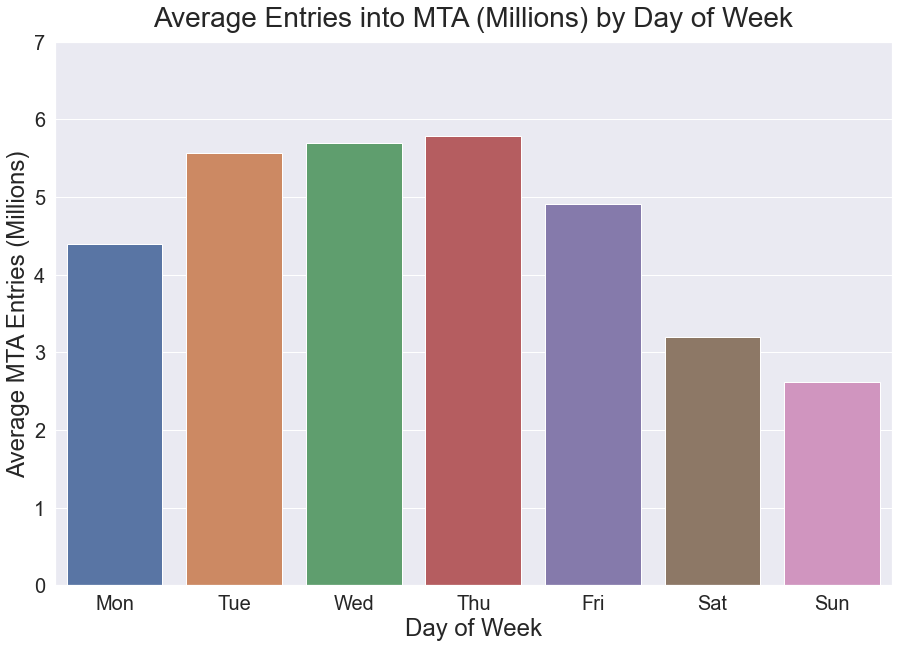

In [445]:
sns.set(rc={'figure.figsize':(15,10)})

ax = sns.barplot(x=mean_daily_traffic.index, y=mean_daily_traffic)
ax.set(ylim=(0, 7000000))

ax.set_title("Average Entries into MTA (Millions) by Day of Week", fontsize=28, pad=15)
ax.set_xlabel("Day of Week", fontsize = 24)
ax.set_ylabel("Average MTA Entries (Millions)", fontsize=24)

ax.set_xticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"], fontsize=20)

ax.yaxis.set_ticks(np.arange(0,7000000 + 1,1000000))
ax.set_yticklabels([0, 1, 2, 3, 4, 5, 6, 7], fontsize=20);

The lower traffic on weekends, combined with the fact that people traveling in New York on weekends may be more likely to be visitors, suggests that weekends would be less fruitful for WTWY's signature-gathering efforts. Let's drop the weekend data. Additionally, let's group by station as we're suggesting stations rather than turnstiles.

In [449]:
stations_by_timeslot = (turnstiles_by_timeslot.groupby(['STATION','DATE_TIME', 'DATE', 'TIME', 'DOW_INDEX'])['NUM_ENTRIES'].sum()
                 .reset_index())
stations_by_timeslot_weekdays = stations_by_timeslot[stations_by_timeslot['DOW_INDEX'] < 5]

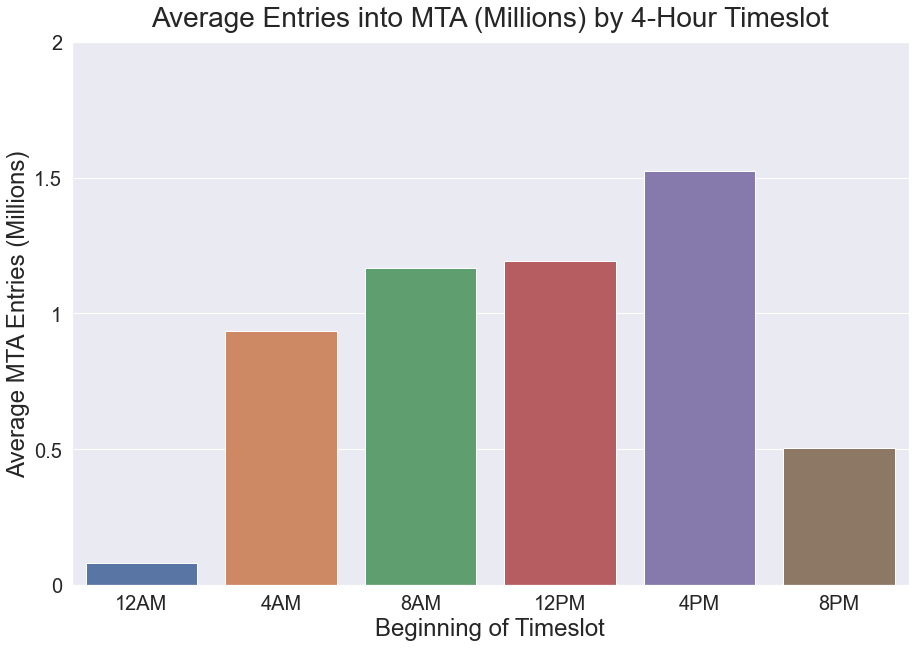

In [478]:
all_weekday_traffic_by_timeslot = stations_by_timeslot_weekdays.groupby(["TIME", "DATE"])["NUM_ENTRIES"]\
                                    .sum().groupby("TIME").mean()

sns.set(rc={'figure.figsize':(15,10)})

ax = sns.barplot(x=all_weekday_traffic_by_timeslot.index, y=all_weekday_traffic_by_timeslot)
ax.set(ylim=(0, 2000000))

ax.set_title("Average Entries into MTA (Millions) by 4-Hour Timeslot", fontsize=28, pad=15)
ax.set_xlabel("Beginning of Timeslot", fontsize = 24)
ax.set_ylabel("Average MTA Entries (Millions)", fontsize=24)

ax.set_xticklabels(["12AM", "4AM", "8AM", "12PM", "4PM", "8PM"], fontsize=20)

ax.yaxis.set_ticks(np.arange(0,2000000 + 1,500000))
ax.set_yticklabels([0, 0.5, 1, 1.5, 2], fontsize=20);

In [ ]:
all_weekday_traffic_by_timeslot = stations_by_timeslot_weekdays.groupby(["TIME"])\
                                    .mean()

# sum by station first
ax = sns.barplot(x=all_traffic_by_time_interval.index, y=all_traffic_by_time_interval.values);
ax.set(ylim=(0, 2000000));
ax.set_xlabel("Beginning of Timeslot", fontsize=20)
ax.set_ylabel("Average Weekday MTA Entries (Millions)", fontsize=20)
ax.set_title("Average Weekday Entries into MTA (Millions) per Four Hours", fontsize=24, pad=13)
ax.yaxis.set_ticks([0, 500000, 1000000, 1500000, 2000000])
ax.set_yticklabels([0.0, 0.5, 1.0, 1.5, 2.0], fontsize=16)
ax.set_xticklabels(["12AM", "4AM", "8AM", "12PM", "4PM", "8PM"], fontsize=16)
sns.set_style("whitegrid")
# we can safely drop midnight & 8PM. due to the nature of our data it's harder to distinguish 4AM and 8AM,
# but for now we assume people don't want to get to work at 4AM.